In [1]:
import glob, matplotlib, pandas, argparse
import numpy as np
# The following package is used to scan through different values of k and find the optimal value using the gap
# and gap* statistic. More info here https://github.com/milesgranger/gap_statistic
from gap_statistic import OptimalK
#from kmeanstf import KMeansTF
#km = KMeansTF.self_test()
#from kmeans_pytorch import kmeans as KMeansPT

# Beautification of plot utilities
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, QuantileTransformer

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [2]:
from data_ttMET_delphes import get_DataLoaders, quantScaler
args = argparse.Namespace()
args.data = '/users/whopkins/sigclustering/sigclustering/python/ttMET_delphes_sepSigs.h5'
args.time_throughput = False
args.batch_size = 128
trainBranches = ['pT_1jet', 'pT_2jet']#, 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets']
varListStr = '_'.join(trainBranches)
signals = ['sig_1300_1', 'sig_700_100', 'sig_500_350']#, 'sig_800_1' , 'sig_800_500']
trainDataLoader, testDataLoader, allData, scaledData, selectedSigs, reducedData = get_DataLoaders(args, trainBranches, signals=signals, minSize=1000, scaler=quantScaler)
print(allData.keys())

No preselection specified
Number of signal samples: 3
Total number of events to be clustered: 66389
We will make all samples have the following raw event yield: 4059
using only samples:  ['sig_1300_1', 'sig_700_100', 'sig_500_350']
aeData.shape: (12177, 2)
aeData.columns: Index(['pT_1jet', 'pT_2jet'], dtype='object')
tempWeights.shape: (12177, 91)
samples: ['sig_1300_1', 'sig_500_350', 'sig_700_100']
tmp =      pT_1jet  pT_2jet
min      0.0      0.0
max      1.0      1.0
Index(['nj_good', 'num_bjets', 'pT_1jet', 'eta_1jet', 'phi_1jet', 'm_1jet',
       'pT_2jet', 'eta_2jet', 'phi_2jet', 'm_2jet', 'pT_3jet', 'eta_3jet',
       'phi_3jet', 'm_3jet', 'pT_4jet', 'eta_4jet', 'phi_4jet', 'm_4jet',
       'pT_5jet', 'eta_5jet', 'phi_5jet', 'm_5jet', 'pT_6jet', 'eta_6jet',
       'phi_6jet', 'm_6jet', 'pT_7jet', 'eta_7jet', 'phi_7jet', 'm_7jet',
       'pT_8jet', 'eta_8jet', 'phi_8jet', 'm_8jet', 'pT_9jet', 'eta_9jet',
       'phi_9jet', 'm_9jet', 'pT_10jet', 'eta_10jet', 'phi_10jet', 'm_10jet

['sig_1300_1', 'sig_700_100', 'sig_500_350']


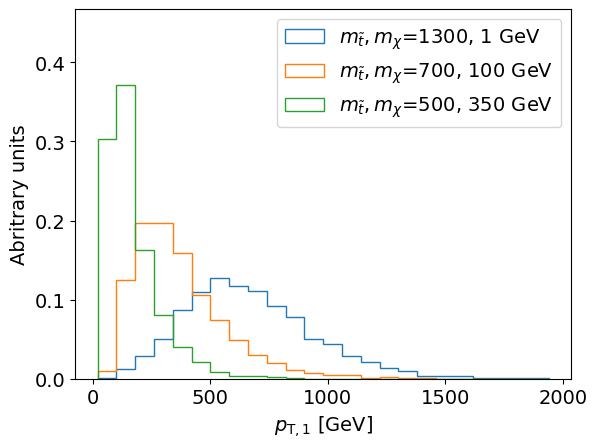

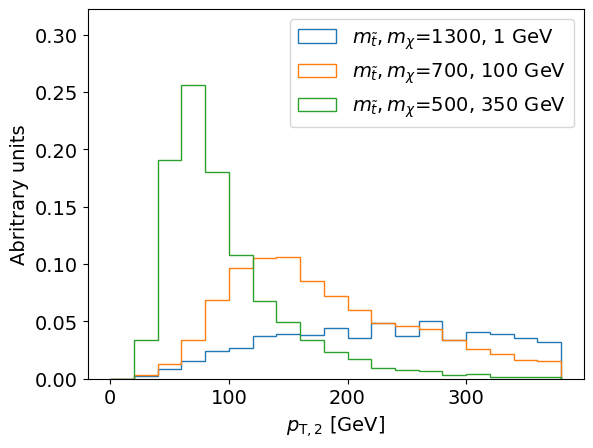

In [3]:
# Let's make histograms of the variables used for clustering to have an idea
# of how the different samples look.
#print(selectedSigs[scaledData.sampName=="sig_500_200"][trainBranches].max())
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, samp in enumerate(signals):
    if 'sig' in samp:
        stopMass = samp.split('_')[1]
        lspMass = samp.split('_')[2]
        prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        #prettySampNames[samp] = f'SUSY model {sampNum+1}' 
for varName in trainBranches:
    fig, ax = plt.subplots()
    for samp in signals:
        sampData = selectedSigs[selectedSigs['sampName'] == samp]
        weights = np.ones((sampData.shape[0]))/sampData.shape[0]
        if varName in binnings:
            plt.hist(sampData[varName], histtype='step', bins=binnings[varName], label=prettySampNames[samp], weights=weights)
        else:
            plt.hist(sampData[varName], histtype='step', label=prettySampNames[samp], weights=weights)
        
    ax.set_ylabel('Abritrary units')
    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
        for varType in units:
            if varType in varName:
                xlabel += f' [{units[varType]}]'
                break
    ax.set_xlabel(xlabel)
    ax.legend(loc=0)
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    plt.savefig(f'{varName}.pdf', bbox_inches='tight')
    plt.savefig(f'{varName}.svg', bbox_inches='tight')
print(signals)

In [4]:
# newColumns=[trainBranch for trainBranch in trainBranches]
# newColumns.append('sampName')
# myScaledData = selectedSigs[newColumns].copy(deep=True)
# scalers = {}
# minScale = 0
# maxScale = 1
# nBins = 20
# nanEq = -90
# for column in trainBranches:
#     scaler = QuantileTransformer()#n_quantiles=10)#PowerTransformer('box-cox')
#     minMaxScaler = MinMaxScaler([minScale, maxScale])
#     mask = myScaledData[column] < nanEq
#     myScaledData.loc[mask, column] = -1.*(maxScale-minScale)/nBins
#     myScaledData.loc[~mask, column] = scaler.fit_transform(myScaledData.loc[~mask, [column]].to_numpy())
#     #myScaledData.loc[~mask, column] = scaler.fit_transform(myScaledData.loc[~mask, [column]].to_numpy())
    

#print(myScaledData)
myScaledData=scaledData
#print(scaledData)

In [5]:
# Needed to define my own clusterer to add the weights when using OptimalK. Not needed when using KMeans from scikit-learn directly.

def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = MiniBatchKMeans(n_clusters=k,random_state=random_state)
    #m = KMeans(n_clusters=k, random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

clusteringData = myScaledData[trainBranches].copy(deep=True)
k_max=10
#optimalK = OptimalK(n_jobs=10, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':rawDataPresel.weight})
optimalK = OptimalK(n_jobs=10, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':np.ones(scaledData.shape[0])})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))
# print(clusteringData.shape)
# import time
# nclust=100
# start = time.time()
# m = KMeans(n_clusters=nclust, random_state=randomState)#, batch_size=1000)
# m.fit(clusteringData.to_numpy())
# print("MiniBatch on CPU", time.time() - start)

# start = time.time()
# mTF = KMeansTF(n_clusters=nclust, random_state=randomState)
# mTF.fit(clusteringData.to_numpy())
# print("KMeansTF", time.time() - start)


3


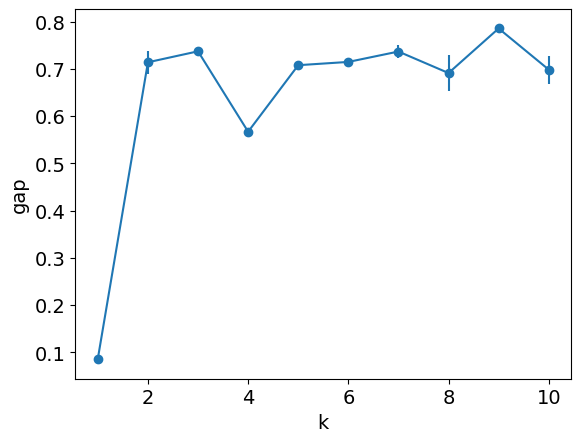

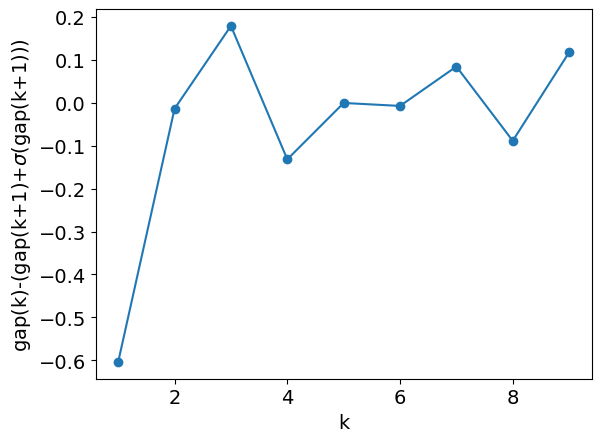

In [6]:
# Find the optimal K
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig("gap_new.svg",bbox_inches='tight')
plt.savefig("gap_new.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)+$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig("diff.svg",bbox_inches='tight')
plt.savefig("diff.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)

2


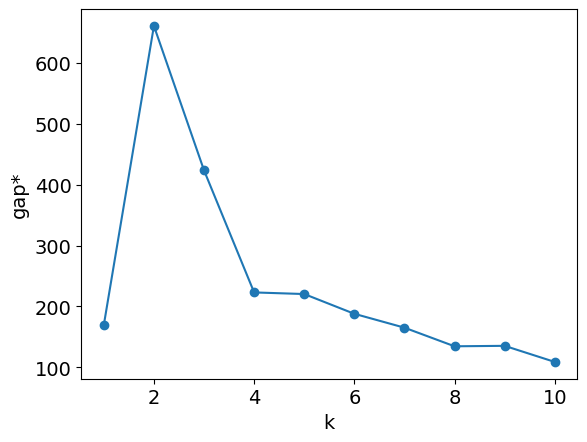

In [7]:
# Repeat for gap*. The outcome is not expected to be consistent but it's interesting to see alternatives.
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
plt.savefig("gapstar.svg",bbox_inches='tight')
plt.savefig("gapstar.pdf",bbox_inches='tight')

# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
print(bestKStar)
# The gap statistics overestimates the number of clusters when there are many clusters.
if bestK >=5 and bestKStar > 1:
    bestK = bestKStar

In [8]:
# Get the centroids and lables.
bestNClus = bestK
Kmean = MiniBatchKMeans(n_clusters=bestNClus, random_state=randomState)
Kmean.fit(clusteringData.to_numpy())
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_
print(centroids)

[[0.499758   0.47555631]
 [0.17908123 0.1901293 ]
 [0.78011646 0.7923622 ]]


pT_1jet


pT_2jet


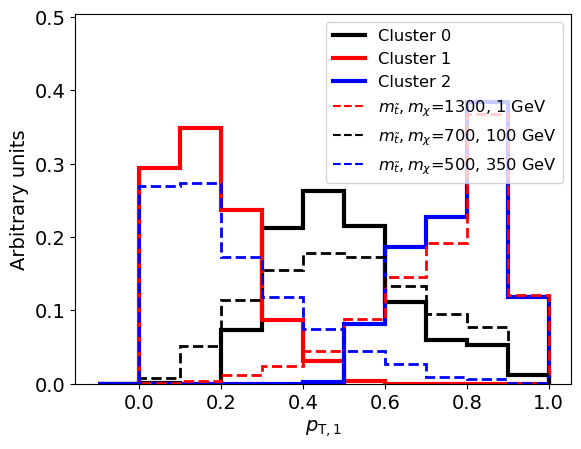

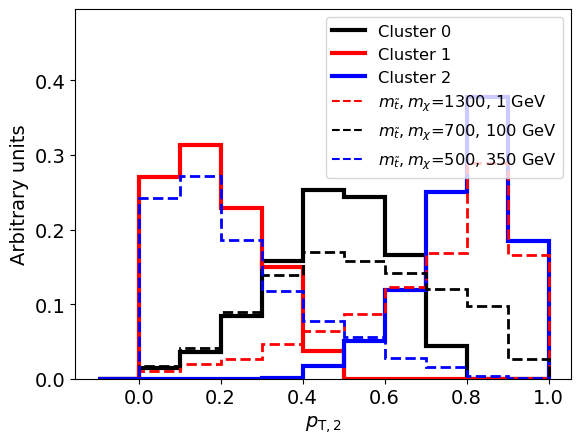

In [9]:
# Plot the 1D histograms of the data points belonging to various clusters
markers = ['s', 'P', 'o']
sampColors = ['r','k', 'b']
clusColors = ['k','r', 'b', 'g', 'y', 'c', 'm']
legHandles = []
for clusColor in clusColors[:bestNClus]:
    legHandles.append(matplotlib.lines.Line2D([], [], c=clusColor, linewidth=3))
for sampColor in sampColors[:len(signals)]:
    legHandles.append(matplotlib.lines.Line2D([], [], c=sampColor, linestyle='dashed'))
minFracOfTotal = 0.1
labels = []
bins = [-0.1+0.1*i for i in range(12)]
for varName in trainBranches:
    print(varName)
    fig, ax = plt.subplots()
    for clusI in range(bestNClus):
        clusData = clusteringData[clusLabels==clusI]
        # Don't bother with clusters that are poorly represented ()
        if clusData.shape[0]/clusteringData.shape[0] < minFracOfTotal:
            print('boo')
            continue
        a = plt.hist(clusData[varName], bins=bins, histtype='step', weights=np.ones(clusData[varName].shape[0])/clusData[varName].shape[0], label=f"Cluster {clusI}", color=clusColors[clusI], linewidth=3)
        labels.append(f"Cluster {clusI}")
    for color, sampLabel in zip(sampColors,signals):
        y_values, bin_edges = np.histogram(myScaledData[myScaledData.sampName==sampLabel][varName], bins=bins)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        #plt.plot(bin_centers, y_values/myScaledData[myScaledData.sampName==sampLabel][varName].shape[0], color+'o', label=prettySampNames[sampLabel])
        plt.hist(myScaledData[myScaledData.sampName==sampLabel][varName], bins=bins, histtype='step', weights=np.ones(myScaledData[myScaledData.sampName==sampLabel][varName].shape[0])/myScaledData[myScaledData.sampName==sampLabel][varName].shape[0], color=color, linestyle='dashed', linewidth=2)
        labels.append(prettySampNames[sampLabel])

    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Arbitrary units')
    ax.set_ylim(0, ax.get_ylim()[1]*1.25)
    ax.legend(ncol=1, handles=legHandles, labels=labels, fontsize='small')
    plt.savefig(f"{varName}_postclustering.svg",bbox_inches='tight')
    plt.savefig(f"{varName}_postclustering.pdf",bbox_inches='tight')


In [10]:
# Plot the 2D histograms (since we only have two variables that we are clustering in)
# and also plot the cluster boundaries.

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = 0,1.1
y_min, y_max = 0,1.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
temp = np.c_[xx.ravel(), yy.ravel()]
print(temp.dtype, clusteringData.to_numpy().dtype)
temp = np.array(temp, dtype='float32')
z = Kmean.predict(temp)
z = z.reshape(xx.shape)
# Put the result into a color plot

bins2d = [[i*.05 for i in range(21)], [i*.05 for i in range(21)]]
colorMaps = [plt.cm.Reds, plt.cm.Greys, plt.cm.Blues]
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

for color, cmap, sampLabel in zip(sampColors, colorMaps, signals):
    fig, ax = plt.subplots()
    plotData = myScaledData[myScaledData.sampName==sampLabel]
    plt.hist2d(plotData[trainBranches[0]], plotData[trainBranches[1]], bins=bins2d, cmap=cmap)
    plt.contour(xx, yy, z, levels=3, colors='g', linewidths=[3])
    cluster1Text = ax.text(0.15, 0.05, 'Cluster 1', ha="center", va="center", color=sampColors[2], fontsize=20)
    cluster2Text = ax.text(0.8, 0.05, 'Cluster 2', ha="center", va="center", color=sampColors[1], fontsize=20)
    cluster3Text = ax.text(0.15, 0.8, 'Cluster 3', ha="center", va="center", color=sampColors[0], fontsize=20)
    legHandles = [mpatches.Patch(color=color, label=prettySampNames[sampLabel])]
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    fontsize=18
    ax.set_xlabel(varLabels[trainBranches[0]], fontsize=fontsize)
    ax.set_ylabel(varLabels[trainBranches[1]], fontsize=fontsize)
    ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=2)
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"complex_{sampLabel}_2DHist_postclustering.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"complex_{sampLabel}_2DHist_postclustering.pdf",bbox_inches='tight', pad_inches=0)

float64 float64


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'